In [1]:
import networkx as nx
import numpy as np
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
from collections import defaultdict
from gensim.models import Word2Vec
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import seaborn as sns

# Pipeline

### Data Loader

In [2]:
def load_data(file_name):
    """
    read edges from an edge file
    """
    edges = list()
    df = pd.read_csv(file_name)
    for idx, row in df.iterrows():
        user_id, friends = row["user_id"], eval(row["friends"])
        for friend in friends:
            # add each friend relation as an edge
            edges.append((user_id, friend))
    edges = sorted(edges)

    return edges

def load_test_data(file_name):
    """
    read edges from an edge file
    """
    edges = list()
    scores = list()
    df = pd.read_csv(file_name)
    for idx, row in df.iterrows():
        edges.append((row["src"], row["dst"]))
        scores.append(row["score"])
    #edges = sorted(edges)

    return edges,scores

def generate_false_edges(true_edges, num_false_edges=5):
    """
    generate false edges given true edges
    """
    nodes = list(set(chain.from_iterable(true_edges)))
    N = len(nodes)
    true_edges = set(true_edges)
    print(N, len(true_edges))
    false_edges = set()

    while len(false_edges) < num_false_edges:
        # randomly sample two different nodes and check whether the pair exisit or not
        src, dst = nodes[int(np.random.rand() * N)], nodes[int(np.random.rand() * N)]
        if src != dst and (src, dst) not in true_edges and (src, dst) not in false_edges:
            false_edges.add((src, dst))
    false_edges = sorted(false_edges)

    return false_edges

def construct_graph_from_edges(edges):
    """
    generate a directed graph object given true edges
    DiGraph documentation: https://networkx.github.io/documentation/stable/reference/classes/digraph.html
    """
    # convert a list of edges {(u, v)} to a list of edges with weights {(u, v, w)}
    edge_weight = defaultdict(float)
    for e in edges:
        edge_weight[e] += 1.0
    weighed_edge_list = list()
    for e in sorted(edge_weight.keys()):
        weighed_edge_list.append((e[0], e[1], edge_weight[e]))

    graph = nx.DiGraph()
    graph.add_weighted_edges_from(weighed_edge_list)

    print("number of nodes:", graph.number_of_nodes())
    print("number of edges:", graph.number_of_edges())

    return graph

### Random Walk Generator

In [3]:
def alias_setup(probs):
    """
    compute utility lists for non-uniform sampling from discrete distributions.
    details: https://lips.cs.princeton.edu/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
    """
    K = len(probs)
    q = np.zeros(K)
    J = np.zeros(K, dtype=int)

    smaller = list()
    larger = list()
    for kk, prob in enumerate(probs):
        q[kk] = K * prob
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)

    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        q[large] = q[large] + q[small] - 1.0
        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q

def get_alias_node(graph, node):
    """
    get the alias node setup lists for a given node.
    """
    # get the unnormalized probabilities with the first-order information
    unnormalized_probs = list()
    for nbr in graph.neighbors(node):
        unnormalized_probs.append(graph[node][nbr]["weight"])
    unnormalized_probs = np.array(unnormalized_probs)
    if len(unnormalized_probs) > 0:
        normalized_probs = unnormalized_probs / unnormalized_probs.sum()
    else:
        normalized_probs = unnormalized_probs

    return alias_setup(normalized_probs)

def get_alias_edge(graph, src, dst, p=1, q=1):
    """
    get the alias edge setup lists for a given edge.
    """
    # get the unnormalized probabilities with the second-order information
    unnormalized_probs = list()
    for dst_nbr in graph.neighbors(dst):
        if dst_nbr == src: # distance is 0
            unnormalized_probs.append(graph[dst][dst_nbr]["weight"]/p)
        elif graph.has_edge(dst_nbr, src): # distance is 1
            unnormalized_probs.append(graph[dst][dst_nbr]["weight"])
        else: # distance is 2
            unnormalized_probs.append(graph[dst][dst_nbr]["weight"]/q)
    unnormalized_probs = np.array(unnormalized_probs)
    if len(unnormalized_probs) > 0:
        normalized_probs = unnormalized_probs / unnormalized_probs.sum()
    else:
        normalized_probs = unnormalized_probs

    return alias_setup(normalized_probs)

def preprocess_transition_probs(graph, p=1, q=1):
    """
    preprocess transition probabilities for guiding the random walks.
    """
    alias_nodes = dict()
    for node in graph.nodes():
        alias_nodes[node] = get_alias_node(graph, node)

    alias_edges = dict()
    for edge in graph.edges():
        alias_edges[edge] = get_alias_edge(graph, edge[0], edge[1], p=p, q=q)

    return alias_nodes, alias_edges

In [4]:
def alias_draw(J, q):
    """
    draw sample from a non-uniform discrete distribution using alias sampling.
    """
    K = len(J)

    kk = int(np.floor(np.random.rand() * K))
    if np.random.rand() < q[kk]:
        return kk
    else:
        return J[kk]


# helper function to generate the long random walk as desired
def fallback(walk, fetch_last_num=1):
    if len(walk) > fetch_last_num:
        walk.pop()
        fetched = []
        for i in range(fetch_last_num):
            fetched.append(walk[-1-i])
        return walk, fetched
    else:
        return [], [None for _ in range(fetch_last_num)]

def generate_first_order_random_walk(graph, alias_nodes,
                                     walk_length=10, start_node=None, verbose=False, max_trails=10):
    """
    simulate a random walk starting from start node and considering the first order information.
    max_trials: set the max trials to be one for standard random walk. Larger max_trails will make the generated biased.
    """
    if start_node == None:
        start_node = np.random.choice(graph.nodes())
    walk = [start_node]
    cur = start_node
    num_tried = 0

    ########## begin ##########
    while len(walk) < walk_length:
        cur_nbrs = list(graph.neighbors(cur))
        if len(cur_nbrs) > 0: # if we can sample next nodes
            # sample the next node based on alias_nodes
            cur = cur_nbrs[alias_draw(*alias_nodes[cur])]
            walk.append(cur)
        else: # if we can't do that
            num_tried += 1
            if num_tried >= max_trails:
                break

            walk, fetched = fallback(walk, fetch_last_num=1)
            cur = fetched[0]
            if len(walk) == 0: # if falls back to the empty walk
                start_node = np.random.choice(graph.nodes())
                walk = [start_node]
                cur = start_node
    ########## end ##########

    if verbose:
        print(f'walk of lenght {len(walk)} generated with {num_tried} trails')
    return walk

def generate_second_order_random_walk(graph, alias_nodes, alias_edges,
                                      walk_length=10, start_node=None, verbose=False, max_trails=10):
    """
    simulate a random walk starting from start node and considering the second order information.
    """
    if start_node == None:
        start_node = np.random.choice(graph.nodes())
    walk = [start_node]

    prev = None
    cur = start_node
    num_tried = 0

    ########## begin ##########
    while len(walk) < walk_length:
        cur_nbrs = list(graph.neighbors(cur))
        if len(cur_nbrs) > 0:
            if prev is None:
                # sample the next node based on alias_nodes
                prev, cur = cur, cur_nbrs[alias_draw(*alias_nodes[cur])]
            else:
                # sample the next node based on alias_edges
                prev, cur = cur, cur_nbrs[alias_draw(*alias_edges[(prev, cur)])]
            walk.append(cur)
        else:
            num_tried += 1
            if num_tried >= max_trails:
                break
            walk, (cur, prev) = fallback(walk, fetch_last_num=2)
            if len(walk) == 0:
                start_node = np.random.choice(graph.nodes())
                walk = [start_node]
                cur = start_node
                prev = None
    ########## end ##########
    if verbose:
        print(f'walk of lenght {len(walk)} generated with {num_tried} trails')
    return walk

### Network Embedding Algorithms

In [5]:
def build_deepwalk(graph, alias_nodes, node_dim=10, num_walks=10, walk_length=10):
    """
    build a deepwalk model
    """
    print("building a DeepWalk model...", end="\t")
    st = time.time()
    np.random.seed(0)
    nodes = list(graph.nodes())
    walks = list()
    # generate random walks
    for walk_iter in range(num_walks):
        np.random.shuffle(nodes)
        for node in nodes:
            walks.append(generate_first_order_random_walk(
                graph, alias_nodes, walk_length=walk_length, start_node=node))

    walk_lens = [len(w) for w in walks]
    if len(walk_lens) > 0:
        avg_walk_len = sum(walk_lens) / len(walk_lens)
    else:
        avg_walk_len = 0.0
    print("number of walks: %d\taverage walk length: %.4f" % (len(walks), avg_walk_len), end="\t")

    # train a skip-gram model for these walks
    model = Word2Vec(walks, vector_size=node_dim, window=3, min_count=0, sg=1, workers=os.cpu_count(), epochs=10)
    print("training time: %.4f" % (time.time()-st))

    return model

def build_node2vec(graph, alias_nodes, alias_edges, node_dim=10, num_walks=10, walk_length=10):
    """
    build a node2vec model
    """
    print("building a node2vec model...", end="\t")
    st = time.time()
    np.random.seed(0)
    nodes = list(graph.nodes())
    walks = list()
    # generate random walks
    for walk_iter in range(num_walks):
        np.random.shuffle(nodes)
        for node in nodes:
            walks.append(generate_second_order_random_walk(
                graph, alias_nodes, alias_edges, walk_length=walk_length, start_node=node))

    walk_lens = [len(w) for w in walks]
    if len(walk_lens) > 0:
        avg_walk_len = sum(walk_lens) / len(walk_lens)
    else:
        avg_walk_len = 0.0
    print("number of walks: %d\taverage walk length: %.4f" % (len(walks), avg_walk_len), end="\t")

    # train a skip-gram model for these walks
    model = Word2Vec(walks, vector_size=node_dim, window=3, min_count=0, sg=1, workers=os.cpu_count(), epochs=10)
    print("training time: %.4f" % (time.time()-st))

    return model

### Scorer

In [7]:
def get_cosine_sim(model, u, v):
    """
    get the cosine similarity between two nodes
    """
    try:
        u = model.wv[u]
        v = model.wv[v]
        return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))
    except:
        return 0.5

def get_auc_score(model, true_edges, false_edges):
    """
    get the auc score
    """
    y_true = [1] * len(true_edges) + [0] * len(false_edges)

    y_score = list()
    for e in true_edges:
        y_score.append(get_cosine_sim(model, e[0], e[1]))
    for e in false_edges:
        y_score.append(get_cosine_sim(model, e[0], e[1]))

    return roc_auc_score(y_true, y_score)

def get_auc_score_test(model, edges,scores):
    """
    get the auc score
    """
    y_true = scores

    y_score = list()
    for e in edges:
        y_score.append(get_cosine_sim(model, e[0], e[1]))

    return roc_auc_score(y_true, y_score)


def write_pred(file_name, edges, scores):
    df = pd.DataFrame()
    df["src"] = [e[0] for e in edges]
    df["dst"] = [e[1] for e in edges]
    df["score"] = scores
    df.to_csv(file_name, index=False)

def write_valid_ans(file_name, edges, scores):
    df = pd.DataFrame()
    df["src"] = [e[0] for e in edges]
    df["dst"] = [e[1] for e in edges]
    df["score"] = scores
    df.to_csv(file_name, index=False)

### Tuning Setup

In [8]:
train_file = "data/train.csv"
valid_file = "data/valid.csv"
test_file = "data/test.csv"

train_edges = load_data(train_file)
valid_edges = load_data(valid_file)
test_edges,test_scores = load_test_data(test_file)

np.random.seed(2024)
graph = construct_graph_from_edges(train_edges)
false_edges = generate_false_edges(train_edges + valid_edges, 40000 - len(valid_edges))

number of nodes: 72795
number of edges: 100000
85407 120000


### Parameter Tuning node_dim

In [ ]:
np.random.seed(0)

node_dim = [20, 50, 80, 100, 200, 500]
num_walks = 10
walk_length = 10
p = 0.5
q = 0.5

node2vec_scores = []

alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)

for dim in node_dim:
    node2vec_model = build_node2vec(graph, alias_nodes, alias_edges, node_dim=dim, num_walks=num_walks, walk_length=walk_length)
    score = get_auc_score(node2vec_model, valid_edges, false_edges)
    node2vec_scores.append({'dim':dim, 'score':score})

node2vec_scores_df = pd.DataFrame(node2vec_scores)
node2vec_scores_df.to_csv("node2vec_dim.csv", sep='\t', index=False)

[Text(0, 0, '0.672455'),
 Text(0, 0, '0.79216'),
 Text(0, 0, '0.825932'),
 Text(0, 0, '0.835613'),
 Text(0, 0, '0.846442'),
 Text(0, 0, '0.842799')]

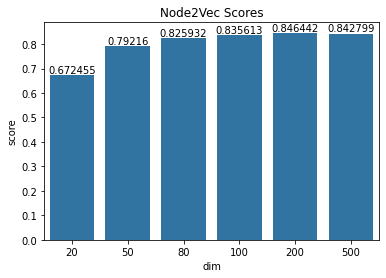

In [3]:
node2vec_scores = pd.read_csv("node2vec_dim.csv", sep='\t')
ax_node2vec = sns.barplot(node2vec_scores, x="dim", y="score")
ax_node2vec.set_title("Node2Vec Scores")
ax_node2vec.bar_label(ax_node2vec.containers[0])

### Parameter Tuning (num_walks, walk_length)

In [ ]:
np.random.seed(0)

node_dim = 200
num_walks_list = [10, 20, 30, 50]
walk_length_list = [10, 20, 30, 50]
p = 0.5
q = 0.5

node2vec_scores = []

alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)

for num_walks in num_walks_list:
    for walk_length in walk_length_list:
        print(f'node_dim:{node_dim}, p:{p}, q:{q}, num_walks:{num_walks}, walk_length:{walk_length}')
        node2vec_model = build_node2vec(graph, alias_nodes, alias_edges, node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
        score = get_auc_score(node2vec_model, valid_edges, false_edges)
        node2vec_scores.append({'num_walks':num_walks, 'walk_length':walk_length, 'score':score})

node2vec_scores_df = pd.DataFrame(node2vec_scores)
node2vec_scores_df.to_csv("node2vec_nl.csv", sep='\t', index=False)

Text(33.0, 0.5, 'num_walks')

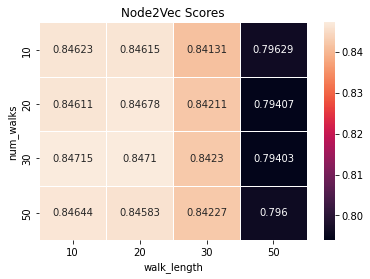

In [4]:
node2vec_scores = np.array(pd.read_csv("node2vec_nl.csv", sep='\t')['score'])
node2vec_scores = np.split(node2vec_scores, 4)
num_walks_list = [10, 20, 30, 50]
walk_length_list = [10, 20, 30, 50]
ax_node2vec = sns.heatmap(node2vec_scores, linewidth=0.5, xticklabels=walk_length_list, yticklabels=num_walks_list, annot=True, fmt='.5g',)
ax_node2vec.set_title("Node2Vec Scores")
ax_node2vec.set_xlabel("walk_length")
ax_node2vec.set_ylabel("num_walks")

### Parameter Tuning (p,q)

In [ ]:
np.random.seed(0)

node_dim = 200
num_walks = 30
walk_length = 10
p_list = [p/10 for p in range(1, 11, 1)]
q_list = [q/10 for q in range(1, 11, 1)]

node2vec_scores = []

for p in p_list:
    for q in q_list:
        print(f'node_dim:{node_dim}, p:{p}, q:{q}, num_walks:{num_walks}, walk_length:{walk_length}')
        alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)
        node2vec_model = build_node2vec(graph, alias_nodes, alias_edges, node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
        score = get_auc_score(node2vec_model, valid_edges, false_edges)
        node2vec_scores.append({'p':p, 'q':q, 'score':score})

node2vec_scores_df = pd.DataFrame(node2vec_scores)
node2vec_scores_df.to_csv("node2vec_pq.csv", sep='\t', index=False)

Text(87.0, 0.5, 'p')

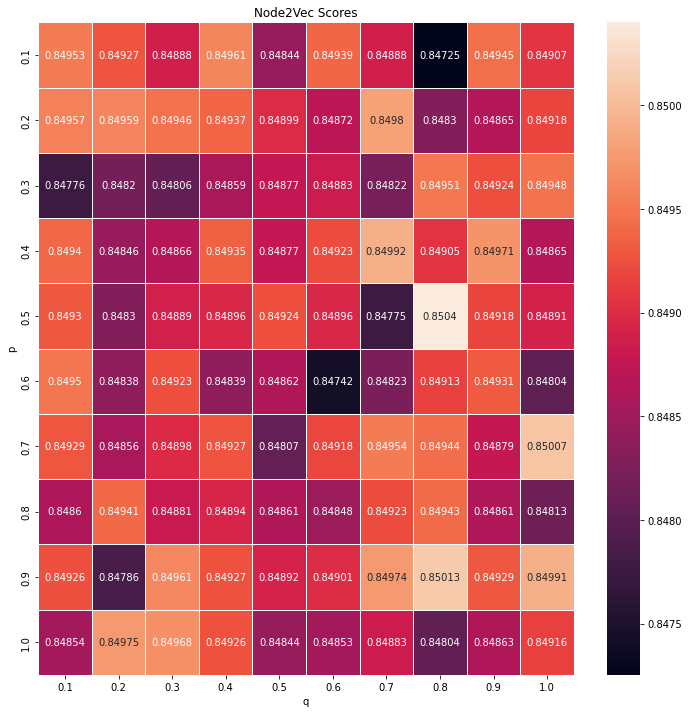

In [5]:
node2vec_scores = np.array(pd.read_csv("node2vec_pq.csv", sep='\t')['score'])
node2vec_scores = np.split(node2vec_scores, 10)
p_list = [p/10 for p in range(1, 11, 1)]
q_list = [q/10 for q in range(1, 11, 1)]
fig, ax = plt.subplots(figsize=(12, 12))
ax_node2vec = sns.heatmap(node2vec_scores, linewidth=0.5, xticklabels=q_list, yticklabels=p_list, annot=True, fmt='.5g',)
ax_node2vec.set_title("Node2Vec Scores")
ax_node2vec.set_xlabel("q")
ax_node2vec.set_ylabel("p")

### Final Model and Predictions on Test Set

In [10]:
np.random.seed(0)

node_dim = 200
num_walks = 30
walk_length = 10
p = 0.5
q = 0.8

print(f'node_dim:{node_dim}, p:{p}, q:{q}, num_walks:{num_walks}, walk_length:{walk_length}')

alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)

model = build_node2vec(graph, alias_nodes,alias_edges, node_dim=node_dim, num_walks=num_walks, walk_length=walk_length) 
scores = [get_cosine_sim(model, src, dst) for src, dst in test_edges]
write_pred("data/pred.csv", test_edges, scores)

node_dim:200, p:0.5, q:0.8, num_walks:30, walk_length:10
building a node2vec model...	number of walks: 2183850	average walk length: 10.0000	training time: 586.6498
